In [2]:
# Import necessary libraries
import os
import pandas as pd
from fredapi import Fred
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import matplotlib.pyplot as plt

# Set up the FRED API key and initialize
FRED_API_KEY = os.getenv('FRED_API_KEY', '8f5bebd7af75a89c64df042058c831a5')
fred = Fred(api_key=FRED_API_KEY)


In [3]:
# Step 1: Fetch economic data from FRED and create DataFrames
# Define a function to download data and save it as CSV
def fetch_and_save_data(series_id, csv_filename, start_date='2018-01-01', end_date='2024-10-31'):
    series_data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
    series_data = series_data.reset_index()
    series_data.columns = ['DATE', series_id]
    series_data.to_csv(csv_filename, index=False)
    print(f"{csv_filename} downloaded successfully!")

# Fetch data from FRED for crude oil prices, corn prices, and other economic indicators
fetch_and_save_data('DCOILWTICO', 'crude_oil_prices.csv')  # Crude Oil Prices
fetch_and_save_data('WPS012202', 'corn_prices.csv')  # Corn Prices
fetch_and_save_data('CUSR0000SETB01', 'gasoline_prices.csv')  # Consumer Price Index for Gasoline
fetch_and_save_data('DHHNGSP', 'natural_gas_prices.csv')  # Henry Hub Natural Gas Prices
fetch_and_save_data('FEDFUNDS', 'federal_funds_rate.csv')  # Federal Funds Rate
fetch_and_save_data('WPU06140341', 'ethanol_prices.csv')  # Ethanol Prices


crude_oil_prices.csv downloaded successfully!
corn_prices.csv downloaded successfully!
gasoline_prices.csv downloaded successfully!
natural_gas_prices.csv downloaded successfully!
federal_funds_rate.csv downloaded successfully!
ethanol_prices.csv downloaded successfully!


In [4]:
# Step 2: Load the fetched CSV files into DataFrames
crude_oil_prices = pd.read_csv('crude_oil_prices.csv')
corn_prices = pd.read_csv('corn_prices.csv')
gasoline_prices = pd.read_csv('gasoline_prices.csv')
natural_gas_prices = pd.read_csv('natural_gas_prices.csv')
federal_funds_rate = pd.read_csv('federal_funds_rate.csv')
ethanol_prices = pd.read_csv('ethanol_prices.csv')

# Display the first few rows of crude oil prices to understand the structure
print(crude_oil_prices.head())


         DATE  DCOILWTICO
0  2018-01-01         NaN
1  2018-01-02       60.37
2  2018-01-03       61.61
3  2018-01-04       61.98
4  2018-01-05       61.49


In [5]:
# Step 3: Convert 'DATE' column to datetime for consistency
crude_oil_prices['DATE'] = pd.to_datetime(crude_oil_prices['DATE'])
corn_prices['DATE'] = pd.to_datetime(corn_prices['DATE'])
gasoline_prices['DATE'] = pd.to_datetime(gasoline_prices['DATE'])
natural_gas_prices['DATE'] = pd.to_datetime(natural_gas_prices['DATE'])
federal_funds_rate['DATE'] = pd.to_datetime(federal_funds_rate['DATE'])
ethanol_prices['DATE'] = pd.to_datetime(ethanol_prices['DATE'])


In [6]:
# Step 4: Merge the dataframes to create a consolidated dataset
merged_data = pd.merge(crude_oil_prices, corn_prices, on='DATE', how='outer')
merged_data = pd.merge(merged_data, gasoline_prices, on='DATE', how='outer')
merged_data = pd.merge(merged_data, natural_gas_prices, on='DATE', how='outer')
merged_data = pd.merge(merged_data, federal_funds_rate, on='DATE', how='outer')
merged_data = pd.merge(merged_data, ethanol_prices, on='DATE', how='outer')

# Display summary statistics
print(merged_data.describe())


                                DATE   DCOILWTICO   WPS012202  CUSR0000SETB01  \
count                           1806  1711.000000   82.000000       82.000000   
mean   2021-05-31 13:44:27.109634816    68.308118  196.704256      268.892756   
min              2018-01-01 00:00:00   -36.980000  114.400000      160.740000   
25%              2019-09-16 06:00:00    56.905000  145.725000      232.623000   
50%              2021-05-31 12:00:00    69.450000  172.968000      255.577000   
75%              2023-02-14 18:00:00    79.525000  245.753250      306.985250   
max              2024-10-31 00:00:00   123.640000  326.444000      411.984000   
std                              NaN    18.491652   58.755911       52.661924   

           DHHNGSP   FEDFUNDS  WPU06140341  
count  1710.000000  82.000000    82.000000  
mean      3.273830   2.273659   236.416171  
min       1.250000   0.050000   148.400000  
25%       2.250000   0.092500   182.150000  
50%       2.710000   1.910000   214.641000  


In [7]:
# Step 5: Handle missing values in the merged dataset
merged_data = merged_data.ffill().bfill()
merged_data.interpolate(method='linear', inplace=True)

# Display the first few rows to confirm the data has been filled properly
print(merged_data.head())


        DATE  DCOILWTICO  WPS012202  CUSR0000SETB01  DHHNGSP  FEDFUNDS  \
0 2018-01-01       60.37      133.4         235.325     6.24      1.41   
1 2018-01-02       60.37      133.4         235.325     6.24      1.41   
2 2018-01-03       61.61      133.4         235.325     6.24      1.41   
3 2018-01-04       61.98      133.4         235.325     4.65      1.41   
4 2018-01-05       61.49      133.4         235.325     4.65      1.41   

   WPU06140341  
0        166.9  
1        166.9  
2        166.9  
3        166.9  
4        166.9  


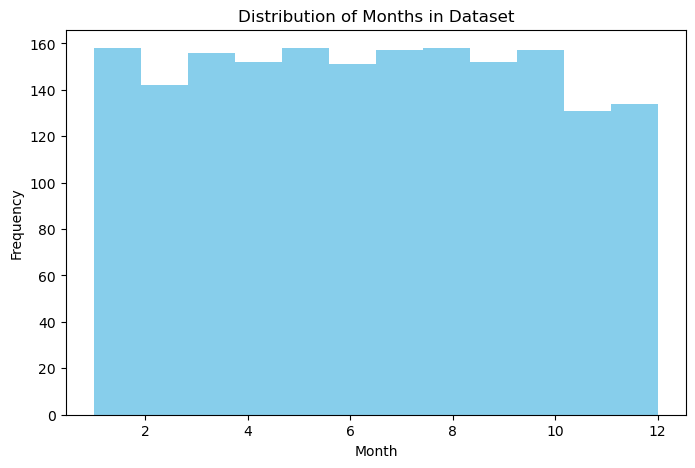

In [8]:
# Step 6: Create additional features for modeling
merged_data['MONTH'] = merged_data['DATE'].dt.month
merged_data['MONTH_SIN'] = np.sin(2 * np.pi * merged_data['MONTH'] / 12)
merged_data['MONTH_COS'] = np.cos(2 * np.pi * merged_data['MONTH'] / 12)

# Plotting the distribution of 'MONTH' feature
plt.figure(figsize=(8, 5))
plt.hist(merged_data['MONTH'], bins=12, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Distribution of Months in Dataset')
plt.show()


In [9]:
# Step 7: Define features and target variable
X = merged_data[['DCOILWTICO', 'WPS012202', 'CUSR0000SETB01', 'DHHNGSP', 'FEDFUNDS', 'MONTH_SIN', 'MONTH_COS']]
y = merged_data['WPU06140341']  # Ethanol Prices

# Display the first few rows of features and target
print(X.head())
print(y.head())


   DCOILWTICO  WPS012202  CUSR0000SETB01  DHHNGSP  FEDFUNDS  MONTH_SIN  \
0       60.37      133.4         235.325     6.24      1.41        0.5   
1       60.37      133.4         235.325     6.24      1.41        0.5   
2       61.61      133.4         235.325     6.24      1.41        0.5   
3       61.98      133.4         235.325     4.65      1.41        0.5   
4       61.49      133.4         235.325     4.65      1.41        0.5   

   MONTH_COS  
0   0.866025  
1   0.866025  
2   0.866025  
3   0.866025  
4   0.866025  
0    166.9
1    166.9
2    166.9
3    166.9
4    166.9
Name: WPU06140341, dtype: float64


In [10]:
# Step 8: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (1444, 7)
Shape of X_test: (362, 7)
Shape of y_train: (1444,)
Shape of y_test: (362,)


In [11]:
# Step 9: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify scaling
print(f"Mean of scaled features (X_train): {np.mean(X_train_scaled, axis=0)}")
print(f"Standard deviation of scaled features (X_train): {np.std(X_train_scaled, axis=0)}")


Mean of scaled features (X_train): [-1.62381650e-16  5.83097744e-16  3.37064940e-16 -1.35318042e-17
  1.78988864e-16  4.92065606e-18  5.22819707e-17]
Standard deviation of scaled features (X_train): [1. 1. 1. 1. 1. 1. 1.]


In [12]:
# Step 10: Train Gradient Boosting Regressor
gbr_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=42)
gbr_model.fit(X_train_scaled, y_train)

# Output message indicating training completion
print("Gradient Boosting Regressor model has been trained successfully!")


Gradient Boosting Regressor model has been trained successfully!


In [13]:
# Step 11: Evaluate the model's performance
y_pred = gbr_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Gradient Boosting Regressor Mean Squared Error:", mse)
print("Gradient Boosting Regressor R² Score:", r2)


Gradient Boosting Regressor Mean Squared Error: 149.3649760712941
Gradient Boosting Regressor R² Score: 0.959250192870673


In [14]:
# Step 12: Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

# Optimized model
gbr_model_optimized = grid_search.best_estimator_
print("Best Parameters from Grid Search:", grid_search.best_params_)

# Retrain with optimized parameters
gbr_model_optimized.fit(X_train_scaled, y_train)


Best Parameters from Grid Search: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}


GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=300,
                          random_state=42)

In [15]:
# Step 13: Re-evaluate Optimized Model
y_pred_optimized = gbr_model_optimized.predict(X_test_scaled)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)
print("Optimized Gradient Boosting Regressor Mean Squared Error:", mse_optimized)
print("Optimized Gradient Boosting Regressor R² Score:", r2_optimized)


Optimized Gradient Boosting Regressor Mean Squared Error: 5.406367607013925
Optimized Gradient Boosting Regressor R² Score: 0.9985250328219455


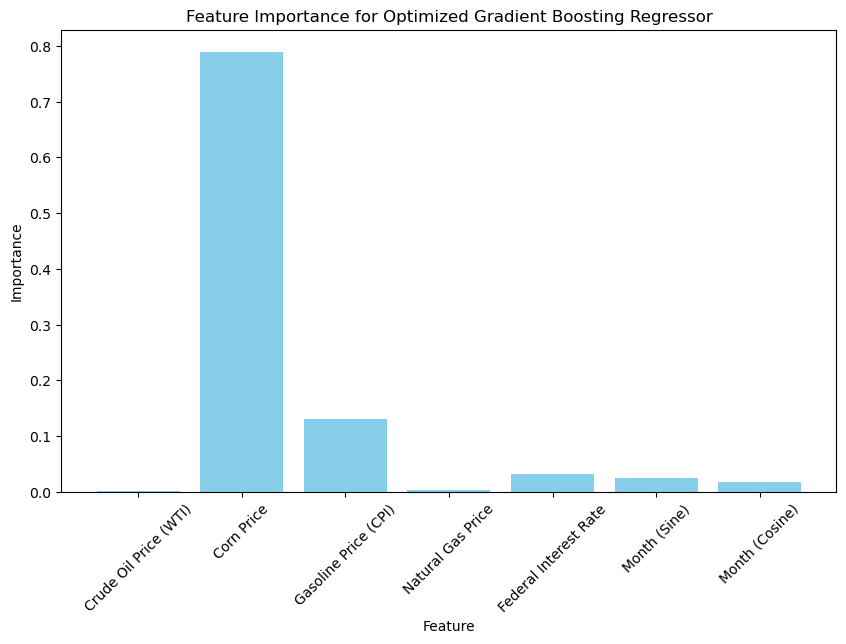

In [16]:
# Step 14: Feature Importance
feature_importance = gbr_model_optimized.feature_importances_
feature_names = [
    'Crude Oil Price (WTI)', 
    'Corn Price', 
    'Gasoline Price (CPI)', 
    'Natural Gas Price', 
    'Federal Interest Rate', 
    'Month (Sine)', 
    'Month (Cosine)'
]

plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance, color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for Optimized Gradient Boosting Regressor')
plt.xticks(rotation=45)
plt.show()


In [17]:
# Update the future dataset without including the 'MONTH' feature
future_data = {
    'DCOILWTICO': [75.0],            # Crude Oil Price (WTI)
    'WPS012202': [6.5],              # Corn Price
    'CUSR0000SETB01': [180.0],       # Gasoline Price (CPI)
    'DHHNGSP': [3.5],                # Natural Gas Price
    'FEDFUNDS': [3.0],               # Federal Interest Rate
    'MONTH_SIN': [np.sin(2 * np.pi * 1 / 12)],  # Sine value for January
    'MONTH_COS': [np.cos(2 * np.pi * 1 / 12)]   # Cosine value for January
}

# Convert the dictionary to a DataFrame
future_df = pd.DataFrame(future_data)

# Ensure the columns are in the exact same order as used in the training set
future_df = future_df[['DCOILWTICO', 'WPS012202', 'CUSR0000SETB01', 'DHHNGSP', 'FEDFUNDS', 'MONTH_SIN', 'MONTH_COS']]

# Scale the future dummy data using the trained scaler
future_scaled = scaler.transform(future_df)

# Make a prediction using the optimized model
future_prediction = gbr_model_optimized.predict(future_scaled)

# Display the predicted ethanol price (PPI) for January 2025
print(f"Predicted Ethanol Price (PPI) for January 2025: {future_prediction[0]}")


Predicted Ethanol Price (PPI) for January 2025: 160.97801801753823


In [18]:
import pickle

# Save the trained model to a .pkl file
with open('gbr_model_optimized.pkl', 'wb') as model_file:
    pickle.dump(gbr_model_optimized, model_file)


In [19]:
import pickle

# Save the scaler to a .pkl file
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)
